# Download data

Run the following code:

```
$ bash
$ pip install git+https://github.com/maciejkula/spotlight.git
$ apt install p7zip
$ cd /tf/notebooks/data
$ mkdir yoochoose
$ curl -Lo yoochoose-data.7z https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z
$ 7z x yoochoose-data.7z
```

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import os

### Clicks dataset

In [4]:
%%time
df_clicks = pd.read_csv("/tf/notebooks/data/yoochoose/" + 'yoochoose-clicks.dat', sep=',', header=None,
                  dtype={0:np.int32, 1:str, 2:np.int64, 3:str})

CPU times: user 19.4 s, sys: 2.98 s, total: 22.4 s
Wall time: 23 s


In [5]:
df_clicks.head()

,0,1,2,3
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


### Managing the category type

In [6]:
# The categories can be S (for promotion), 0 (when unknown), 
# a number between 1-12 when it came from a category on the page
# or a 8-10 digit number that represents a brand

def assign_cat(x):
    if x == "S":
        return "PROMOTION"
    elif np.int(x) == 0:
        return "NONE"
    elif np.int(x) < 13:
        return "CATEGORY"
    else:
        return "BRAND"

Assign the caegory to the clicks dataset

In [7]:
%%time
df_clicks["Item_Type"] = df_clicks.iloc[:,3].map(assign_cat)

CPU times: user 8.46 s, sys: 111 ms, total: 8.57 s
Wall time: 8.57 s


Assign column names

In [8]:
df_clicks.columns =  ["SessionId", "TimeStr", "ItemId", "Item_Type_Code", "ItemType"]

In [9]:
# We can drop item type code now
df_clicks.drop(["Item_Type_Code"], inplace=True, axis=1)

In [10]:
df_clicks.head()

,SessionId,TimeStr,ItemId,ItemType
0,1,2014-04-07T10:51:09.277Z,214536502,NONE
1,1,2014-04-07T10:54:09.868Z,214536500,NONE
2,1,2014-04-07T10:54:46.998Z,214536506,NONE
3,1,2014-04-07T10:57:00.306Z,214577561,NONE
4,2,2014-04-07T13:56:37.614Z,214662742,NONE


# Exploring the data

In [11]:
print("Number of unique sessions:", len(df_clicks.SessionId.unique()))

Number of unique sessions: 9249729


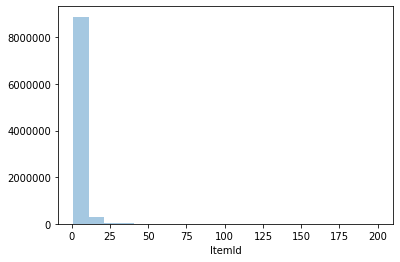

In [12]:
df_clicks_by_session = df_clicks.groupby(["SessionId"])
df_clicks_sessionCount = df_clicks_by_session["ItemId"].count()
sns.distplot(df_clicks_sessionCount, kde=False, bins=20)

### Buy dataset

In [13]:
%%time
df_buys = pd.read_csv("/tf/notebooks/data/yoochoose/" + 'yoochoose-buys.dat', sep=',', header=None,
                  dtype={0:np.int32, 1:str, 2:np.int64, 3:np.int64, 4:np.int64})

CPU times: user 650 ms, sys: 100 ms, total: 750 ms
Wall time: 776 ms


In [14]:
df_buys.columns = ["SessionId", "TimeStr", "ItemId", "Price", "Quantity"]
df_buys.drop(["TimeStr"], inplace=True, axis=1)
df_buys["Action"] = "BUY"
df_buys.head()

,SessionId,ItemId,Price,Quantity,Action
0,420374,214537888,12462,1,BUY
1,420374,214537850,10471,1,BUY
2,281626,214535653,1883,1,BUY
3,420368,214530572,6073,1,BUY
4,420368,214835025,2617,1,BUY


In [15]:
%%time
df = pd.merge(left=df_clicks, right=df_buys, how="left", on=["SessionId", "ItemId"])

CPU times: user 12.5 s, sys: 4.7 s, total: 17.2 s
Wall time: 17.2 s


### Sample data 

In [16]:
query = "ItemId==@ItemId & SessionId==@SessionId"

In [17]:
ItemId = 214821371
SessionId = 11

In [18]:
df_clicks.query(query)

,SessionId,TimeStr,ItemId,ItemType
26,11,2014-04-03T10:45:29.873Z,214821371,NONE
27,11,2014-04-03T10:46:12.162Z,214821371,NONE
28,11,2014-04-03T10:46:57.355Z,214821371,NONE


In [19]:
df_buys.query(query)

,SessionId,ItemId,Price,Quantity,Action
10,11,214821371,1046,1,BUY
11,11,214821371,1046,1,BUY


In [20]:
df.query(query)

,SessionId,TimeStr,ItemId,ItemType,Price,Quantity,Action
26,11,2014-04-03T10:45:29.873Z,214821371,NONE,1046.0,1.0,BUY
27,11,2014-04-03T10:45:29.873Z,214821371,NONE,1046.0,1.0,BUY
28,11,2014-04-03T10:46:12.162Z,214821371,NONE,1046.0,1.0,BUY
29,11,2014-04-03T10:46:12.162Z,214821371,NONE,1046.0,1.0,BUY
30,11,2014-04-03T10:46:57.355Z,214821371,NONE,1046.0,1.0,BUY
31,11,2014-04-03T10:46:57.355Z,214821371,NONE,1046.0,1.0,BUY


In [21]:
# Drop duplicates
df.drop_duplicates(inplace=True)

### Sub-select data - based on threshold

In [22]:
SESSION_THRESHOLD = 20
ITEM_THRESHOLD = 1000

In [23]:
session_lengths = df.groupby(["SessionId"]).size()
session_lengths_w_threshold = (session_lengths[session_lengths>SESSION_THRESHOLD]).reset_index()

In [24]:
df_with_session_threshold = df[df.SessionId.isin(session_lengths_w_threshold.SessionId)]

In [25]:
item_lengths = df.groupby(["ItemId"]).size()
item_lengths_w_threshold = item_lengths[item_lengths>ITEM_THRESHOLD]
len(item_lengths_w_threshold)

5131

In [26]:
item_lengths_w_threshold = item_lengths_w_threshold.reset_index()
df_with_session_item_threshold = df_with_session_threshold[df_with_session_threshold.ItemId.isin(item_lengths_w_threshold.ItemId)]

In [27]:
session_lengths_2 = df_with_session_item_threshold.groupby(["SessionId"]).size()
session_lengths_2_w_threshold = (session_lengths_2[session_lengths_2 > SESSION_THRESHOLD]).reset_index()

In [28]:
df_final = df_with_session_item_threshold[df_with_session_item_threshold.SessionId.isin(session_lengths_2_w_threshold.SessionId)]

In [29]:
df_final.head()

,SessionId,TimeStr,ItemId,ItemType,Price,Quantity,Action
282,87,2014-04-07T06:19:20.979Z,214840483,NONE,1674.0,1.0,BUY
283,87,2014-04-07T06:19:28.762Z,214840483,NONE,1674.0,1.0,BUY
284,87,2014-04-07T06:26:01.516Z,214717286,NONE,NaN,NaN,NaN
285,87,2014-04-07T06:26:15.176Z,214558807,NONE,NaN,NaN,NaN
286,87,2014-04-07T06:26:32.159Z,214821300,NONE,NaN,NaN,NaN


In [30]:
df_final.Action.fillna(value="CLICK", inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [31]:
df_final.drop(["Price", "Quantity"], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
df_final.head()

,SessionId,TimeStr,ItemId,ItemType,Action
282,87,2014-04-07T06:19:20.979Z,214840483,NONE,BUY
283,87,2014-04-07T06:19:28.762Z,214840483,NONE,BUY
284,87,2014-04-07T06:26:01.516Z,214717286,NONE,CLICK
285,87,2014-04-07T06:26:15.176Z,214558807,NONE,CLICK
286,87,2014-04-07T06:26:32.159Z,214821300,NONE,CLICK


### Fixing Time

In [33]:
%%time
df_final['Time'] = df_final.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp()) #This is not UTC. It does not really matter.

CPU times: user 11.3 s, sys: 28.3 ms, total: 11.3 s
Wall time: 11.3 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
del(df_final["TimeStr"])

In [35]:
%%time
df_final.sort_values(by=["SessionId", "Time"], inplace=True)

CPU times: user 519 ms, sys: 79.1 ms, total: 598 ms
Wall time: 597 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
df_final["Rating"] = df_final.Action.apply(lambda x: 1 if (x == "CLICK") else 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_final.head()

,SessionId,ItemId,ItemType,Action,Time,Rating
282,87,214840483,NONE,BUY,1.396852e+09,5
283,87,214840483,NONE,BUY,1.396852e+09,5
284,87,214717286,NONE,CLICK,1.396852e+09,1
285,87,214558807,NONE,CLICK,1.396852e+09,1
286,87,214821300,NONE,CLICK,1.396852e+09,1


In [38]:
df_final.to_csv("/tf/notebooks/data/yoochoose/"+"rating.csv", index=False)